In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:99% !important;}</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from tqdm import tqdm
import os

#import tensorflow as tf
#import keras
from keras.layers import Dense, Dropout, Input, Flatten, Reshape, BatchNormalization, Activation, ZeroPadding2D, Embedding, multiply
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping, TensorBoard
from keras.datasets import mnist

Using TensorFlow backend.


# Generate Data

In [3]:
### Image dimensions
M = 28
MM = M*M
SIZE = (M,M)
N = 5000

In [4]:
### y1, y2 locations of start, end points of lines to connect
MU = M/2
SIGMA = 2

r = np.random.normal(MU, SIGMA, size=N*2).clip(0, M-1)
y1, y2 = r[:N], r[N:]

In [5]:
### Connect lines (analogue to digital) via discrete slope
# y = mx + b
# m = (y1-y0)/(x1-x0) = (y1-y0)/M
i = np.arange(M).reshape(-1,1)
y = (i*(y2-y1)/M + y1).astype(int)

Yh, Yv = [], []
for a in y.T:
    ### All lines are 1, all nonlines are 0
    #b = np.zeros(SIZE)
    #b[np.arange(M), a] = 1 
    ### All lines are >0, all nonlines are -1
    b = np.ones(SIZE) * -1
    b[np.arange(M), a] = np.abs(np.random.normal(0, SIGMA, size=M))
    Yh.append(b.T)
    Yv.append(b)
Yh = np.array(Yh)#, np.int8)
Yv = np.array(Yv)#, np.int8)

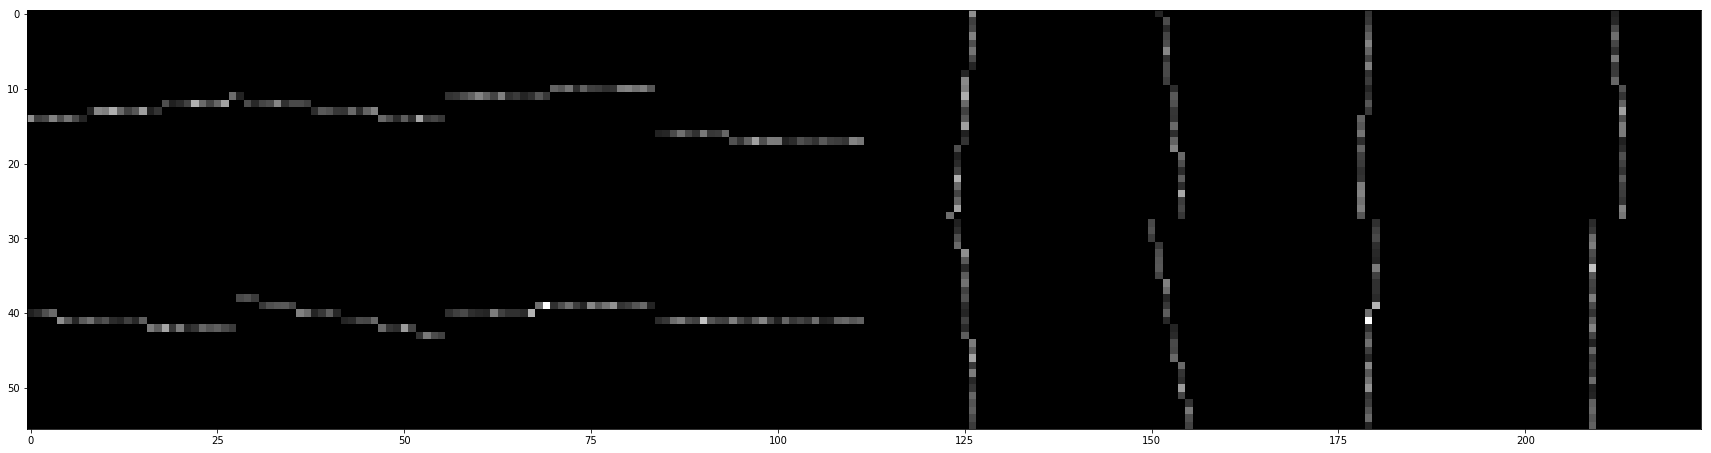

In [6]:
### Plot d*r sample data
d = 4
r = 2

h = np.vstack([np.hstack(Yh[i*d:(i+1)*d]) for i in range(r)])
v = np.vstack([np.hstack(Yv[i*d:(i+1)*d]) for i in range(r)])
hv = np.hstack([h,v])

plt.figure(figsize=(30,10))
plt.imshow(hv, cmap='gray')
plt.show()

In [7]:
### Save down as images
# for e, (h, v) in enumerate(zip(Yh,Yv)):
#     plt.imsave('Data/horizontal_{}.png'.format(e), h)
#     plt.imsave('Data/vertical_{}.png'.format(e), v)

#plt.imshow(plt.imread('Data/horizontal_4989.png')); plt.show()

In [8]:
# ### Reshape 2D images into 1D vector
# Xh_train = Yh.reshape(-1, M*M)
# Xv_train = Yv.reshape(-1, M*M)

# yh_train = np.zeros(Xh_train.shape[0])
# yv_train = np.ones(Xv_train.shape[0])

# Xhv_train = np.append(Xh_train, Xv_train, axis=0)
# yhv_train = np.append(yh_train, yv_train, axis=0)

# def unison_shuffled_copies(a, b):
#     assert len(a) == len(b)
#     p = np.random.permutation(len(a))
#     return a[p], b[p]

# X_train, y_train = unison_shuffled_copies(Xhv_train, yhv_train)

In [9]:
# ### Take random sample(s), reshape 1D vector back into 2D image to plot.
# for _ in range(1):
#     i = np.random.choice(range(len(y_train)))
#     plt.figure()
#     plt.imshow(X_train[i].reshape(M,M), cmap='gray')
#     plt.title('{}: {}'.format(i, 'V' if y_train[i] else 'H'))
#     plt.show()

In [10]:
### Join horizontal, vertical lines for full dataset
#X = np.append(Yh, Yv, axis=0)
#X = Yh.copy()
#X = Yv.copy()
#np.random.shuffle(X)

In [11]:
Xh = Yh.copy()
Xv = Yv.copy()

In [12]:
yh = np.zeros(Xh.shape[0])
yv = np.ones(Xv.shape[0])

In [13]:
X = np.append(Xh, Xv, axis=0)
y = np.append(yh, yv, axis=0)

In [14]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [15]:
 X, y = unison_shuffled_copies(X, y)

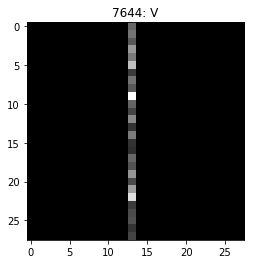

In [16]:
### Take random sample(s), reshape 1D vector back into 2D image to plot.
for _ in range(1):
    i = np.random.choice(range(len(y)))
    plt.figure()
    plt.imshow(X[i], cmap='gray')
    plt.title('{}: {}'.format(i, 'V' if y[i] else 'H'))
    plt.show()

# GAN

In [17]:
class CDCGAN():
    '''https://arxiv.org/abs/1411.1784'''
    def __init__(self, X, Y, model='model', normalize=True):
        self.X = X
        self.nimgs = X.shape[0]
        try:
            self.img_n, self.img_nrows, self.img_ncols, self.img_nchannels = X.shape
        except ValueError:
            self.img_n, self.img_nrows, self.img_ncols = X.shape
            self.img_nchannels = 1
        self.img_shape = (self.img_nrows, self.img_ncols, self.img_nchannels)
        if normalize:
            self.X = self.normalize(self.X)
        self.X = np.expand_dims(self.X, axis=3)
        
        self.Y = Y.reshape(-1,1)
        self.nclasses = np.unique(Y).size

        self.model = model
        self.initializer = RandomNormal(stddev=0.02, seed=0)
        self.optimizer = Adam(lr=0.0002, beta_1=0.5) 
        self.loss = 'binary_crossentropy'

        self.GAN()
        
        dir0 = 'cdcgan'
        self.plot_dir = './{}/{}/plots/'.format(dir0, model)
        self.log_dir = './{}/{}/logs/'.format(dir0, model)
        self.model_dir = './{}/{}/models/'.format(dir0, model)
        if not os.path.exists(self.plot_dir): os.makedirs(self.plot_dir)
        if not os.path.exists(self.log_dir): os.makedirs(self.log_dir)
        if not os.path.exists(self.model_dir): os.makedirs(self.model_dir)
        s = 'Save paths:\n {}\n {}\n {}'
        print(s.format(self.plot_dir, self.log_dir, self.model_dir))

 
    def Generator(self):
        self.latent_dim = 100
        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.nclasses, self.latent_dim)(label))
        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    
    def Discriminator(self):
        model = Sequential()
        model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.nclasses, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)
        model_input = multiply([flat_img, label_embedding])
        validity = model(model_input)

        return Model([img, label], validity)
        

    def GAN(self):
        ### Build and compile the discriminator
        self.discriminator = self.Discriminator()
        self.discriminator.compile(loss=self.loss, optimizer=self.optimizer, 
                                   metrics=['accuracy'])#, 'mse'])

        ### Build the generator, gan
        # The generator takes noise as input and generates imgs
        # The discriminator takes generated images as input and determines validity
        # For the combined model we will only train the generator
        # The combined model (stacked generator and discriminator)
        # trains the generator to fool the discriminator
        self.generator = self.Generator()
        
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])
        
        self.discriminator.trainable = False        
        validity = self.discriminator([img, label])
        self.gan = Model([noise, label], validity)
        self.gan.compile(loss=self.loss, optimizer=self.optimizer,
                         metrics=['acc'])#, 'mse'])
        
    
    def generate_noise(self, dim1, dim2, mu=0, sigma=1):
        return np.random.normal(mu, sigma, (dim1, dim2))
    
    
    def generate_imgs(self, dim1, dim2, labels, reshape=False):
        noise = self.generate_noise(dim1, dim2)
        g_imgs = self.generator.predict([noise, labels])
        if reshape:
            g_imgs = g_imgs.reshape(dim1, self.img_nrows, self.img_ncols)
        return g_imgs, noise
    
    
    def plot_imgs(self, epoch, labels, dim1=1, dim2=10, figsize=(10,10), 
                  plot_dir='./plots/', plot_save=True, plot_show=True):
        g_imgs, _ = self.generate_imgs(dim1*dim2, self.latent_dim, labels, reshape=True)

        plt.figure(figsize=figsize)
        for e,i in enumerate(g_imgs):
            plt.subplot(dim1, dim2, e+1)
            plt.title(labels[e][0])
            plt.imshow(i, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if plot_save:
            plt.savefig('{}{}.png'.format(plot_dir, epoch))
        if plot_show:
            plt.show(block=False)  

    
    def normalize(self, x, alpha=-1, beta=1):
        '''cv.normalize(x, None, -1, 1, cv.NORM_MINMAX) was not normalizing below 0.
        Had to do it myself.'''
        a = x.min()
        b = x.max()
        return (x-a)/(b-a)*(beta-alpha) + alpha

    
    def named_logs(self, model, logs, prefix=False):
        mmn = model.metrics_names
        if prefix: 
            mmn = [prefix+i for i in mmn]
        result = {}
        for l in zip(mmn, logs):
            result[l[0]] = l[1]
        return result

    
    def train(self, epochs, batch_size=32, save_interval=50):
        
        #earlystopping = EarlyStopping(monitor='val_history', mode='min', patience=5, verbose=1)
        
        tensorboard = TensorBoard(log_dir=self.log_dir, histogram_freq=0, 
                                  batch_size=batch_size, 
                                  write_graph=True, write_grads=True)
        tensorboard.set_model(self.discriminator)
        tensorboard.set_model(self.generator)

        # Adversarial ground truths
        # https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9
        # "If you are using Real Images = 1 and Generated Images = 0, 
        # it helps to have it the other way around. As we will see later, 
        # this helps with the gradient flow in the early iterations and 
        # helps get things moving."
        valid = np.zeros((batch_size, 1))
        fake = np.ones((batch_size, 1))
        #valid = np.random.uniform(0, 0.1, (batch_size,1))
        #fake = np.random.uniform(0.9, 1, (batch_size,1))
        #valid = np.zeros((batch_size, 1)) * np.random.uniform(0, 0.1, 1)
        #fake = np.ones((batch_size, 1)) * np.random.uniform(0.9, 1, 1)

        for epoch in range(epochs+1):


            # Select a random batch of images
            mask = np.random.randint(0, self.img_n, batch_size)
            imgs, labels = self.X[mask], self.Y[mask]
            
            # Sample noise and generate a batch of new images
            gen_imgs, noise = self.generate_imgs(batch_size, self.latent_dim, labels)
            
            # Train the discriminator (real classified as ones and generated as zeros)
            d_history_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_history_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_history = 0.5 * np.add(d_history_real, d_history_fake)

            # Train the generator (wants discriminator to mistake images as real)
            sampled_labels = np.random.randint(0, self.nclasses, batch_size).reshape(-1, 1)
            
            g_history = self.gan.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            # If at save interval => save generated image samples
            tensorboard.on_epoch_end(epoch, self.named_logs(self.discriminator, d_history, prefix='d_'))
            tensorboard.on_epoch_end(epoch, self.named_logs(self.discriminator, d_history_real, prefix='d_real_'))
            tensorboard.on_epoch_end(epoch, self.named_logs(self.discriminator, d_history_fake, prefix='d_fake_'))
            tensorboard.on_epoch_end(epoch, self.named_logs(self.gan, g_history, prefix='g_'))

            s = 'Epoch {0: >4}/{1}  ||  D acc: {2:.2f}, loss: {3:.2f}  |  G loss: {4:.2f}'
            print(s.format(epoch, epochs, d_history[1], d_history[0], g_history[0]))

            if epoch % save_interval == 0:
                self.plot_imgs(epoch, sampled_labels, plot_dir=self.plot_dir)
                self.discriminator.save(self.model_dir+'discriminator.h5')
                self.generator.save(self.model_dir+'generator.h5')
                self.gan.save(self.model_dir+'gan.h5')
            

            #if g_history[1] == 1.:
            #    break

In [18]:
# # Load the dataset
# (X, y), (_, _) = mnist.load_data()
# plt.imshow(X[0], cmap='gray'); plt.show()

In [19]:
MODEL = 'model2'
cdcgan = CDCGAN(X, y, MODEL)

Save paths:
 ./cdcgan/model2/plots/
 ./cdcgan/model2/logs/
 ./cdcgan/model2/models/


Instructions for updating:
Use the retry module or similar alternatives.


/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch    0/4000  ||  D acc: 0.30, loss: 0.69  |  G loss: 0.69


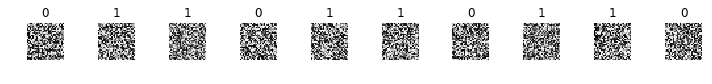

Epoch    1/4000  ||  D acc: 0.59, loss: 0.68  |  G loss: 0.69
Epoch    2/4000  ||  D acc: 0.58, loss: 0.66  |  G loss: 0.69
Epoch    3/4000  ||  D acc: 0.59, loss: 0.64  |  G loss: 0.69
Epoch    4/4000  ||  D acc: 0.80, loss: 0.62  |  G loss: 0.70
Epoch    5/4000  ||  D acc: 0.80, loss: 0.60  |  G loss: 0.71
Epoch    6/4000  ||  D acc: 0.83, loss: 0.58  |  G loss: 0.72
Epoch    7/4000  ||  D acc: 0.89, loss: 0.54  |  G loss: 0.72
Epoch    8/4000  ||  D acc: 0.92, loss: 0.50  |  G loss: 0.75
Epoch    9/4000  ||  D acc: 0.92, loss: 0.46  |  G loss: 0.76
Epoch   10/4000  ||  D acc: 0.98, loss: 0.42  |  G loss: 0.81
Epoch   11/4000  ||  D acc: 0.92, loss: 0.38  |  G loss: 0.83
Epoch   12/4000  ||  D acc: 1.00, loss: 0.34  |  G loss: 0.91
Epoch   13/4000  ||  D acc: 0.97, loss: 0.31  |  G loss: 0.95
Epoch   14/4000  ||  D acc: 0.95, loss: 0.28  |  G loss: 1.01
Epoch   15/4000  ||  D acc: 0.98, loss: 0.27  |  G loss: 1.13
Epoch   16/4000  ||  D acc: 0.98, loss: 0.23  |  G loss: 1.18
Epoch   

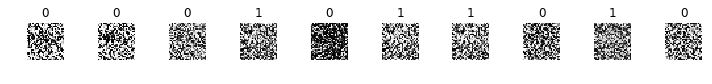

Epoch   51/4000  ||  D acc: 1.00, loss: 0.02  |  G loss: 5.63
Epoch   52/4000  ||  D acc: 1.00, loss: 0.02  |  G loss: 5.69
Epoch   53/4000  ||  D acc: 1.00, loss: 0.01  |  G loss: 5.93
Epoch   54/4000  ||  D acc: 1.00, loss: 0.01  |  G loss: 5.97
Epoch   55/4000  ||  D acc: 1.00, loss: 0.01  |  G loss: 5.66
Epoch   56/4000  ||  D acc: 1.00, loss: 0.01  |  G loss: 5.97
Epoch   57/4000  ||  D acc: 0.98, loss: 0.02  |  G loss: 6.26
Epoch   58/4000  ||  D acc: 0.98, loss: 0.05  |  G loss: 6.03
Epoch   59/4000  ||  D acc: 0.97, loss: 0.08  |  G loss: 7.07
Epoch   60/4000  ||  D acc: 0.98, loss: 0.10  |  G loss: 6.68
Epoch   61/4000  ||  D acc: 0.97, loss: 0.11  |  G loss: 7.51
Epoch   62/4000  ||  D acc: 0.98, loss: 0.05  |  G loss: 7.81
Epoch   63/4000  ||  D acc: 0.67, loss: 0.57  |  G loss: 5.60
Epoch   64/4000  ||  D acc: 0.84, loss: 0.52  |  G loss: 6.17
Epoch   65/4000  ||  D acc: 0.92, loss: 0.26  |  G loss: 6.81
Epoch   66/4000  ||  D acc: 0.97, loss: 0.11  |  G loss: 5.55
Epoch   

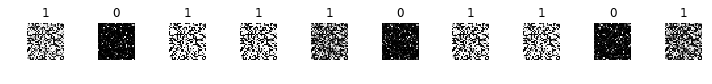

Epoch  101/4000  ||  D acc: 0.83, loss: 0.47  |  G loss: 5.60
Epoch  102/4000  ||  D acc: 0.89, loss: 0.39  |  G loss: 4.39
Epoch  103/4000  ||  D acc: 0.70, loss: 0.55  |  G loss: 5.47
Epoch  104/4000  ||  D acc: 0.97, loss: 0.09  |  G loss: 6.16
Epoch  105/4000  ||  D acc: 0.94, loss: 0.20  |  G loss: 5.75
Epoch  106/4000  ||  D acc: 0.94, loss: 0.20  |  G loss: 6.26
Epoch  107/4000  ||  D acc: 0.95, loss: 0.16  |  G loss: 5.30
Epoch  108/4000  ||  D acc: 0.92, loss: 0.20  |  G loss: 5.55
Epoch  109/4000  ||  D acc: 0.86, loss: 0.29  |  G loss: 5.48
Epoch  110/4000  ||  D acc: 0.88, loss: 0.25  |  G loss: 6.61
Epoch  111/4000  ||  D acc: 0.55, loss: 1.04  |  G loss: 3.98
Epoch  112/4000  ||  D acc: 0.88, loss: 0.35  |  G loss: 4.38
Epoch  113/4000  ||  D acc: 0.89, loss: 0.43  |  G loss: 4.08
Epoch  114/4000  ||  D acc: 0.78, loss: 0.73  |  G loss: 3.93
Epoch  115/4000  ||  D acc: 0.89, loss: 0.29  |  G loss: 4.32
Epoch  116/4000  ||  D acc: 0.89, loss: 0.21  |  G loss: 4.18
Epoch  1

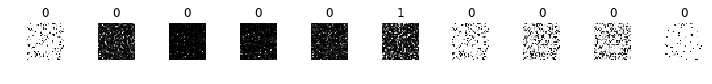

Epoch  151/4000  ||  D acc: 0.81, loss: 0.40  |  G loss: 5.04
Epoch  152/4000  ||  D acc: 0.78, loss: 0.46  |  G loss: 4.98
Epoch  153/4000  ||  D acc: 0.84, loss: 0.37  |  G loss: 4.52
Epoch  154/4000  ||  D acc: 0.67, loss: 0.70  |  G loss: 5.04
Epoch  155/4000  ||  D acc: 0.83, loss: 0.39  |  G loss: 4.90
Epoch  156/4000  ||  D acc: 0.73, loss: 0.50  |  G loss: 5.79
Epoch  157/4000  ||  D acc: 0.62, loss: 0.62  |  G loss: 4.01
Epoch  158/4000  ||  D acc: 0.75, loss: 0.47  |  G loss: 4.74
Epoch  159/4000  ||  D acc: 0.70, loss: 0.55  |  G loss: 4.37
Epoch  160/4000  ||  D acc: 0.69, loss: 0.56  |  G loss: 5.33
Epoch  161/4000  ||  D acc: 0.72, loss: 0.54  |  G loss: 4.75
Epoch  162/4000  ||  D acc: 0.61, loss: 0.64  |  G loss: 5.15
Epoch  163/4000  ||  D acc: 0.73, loss: 0.57  |  G loss: 4.25
Epoch  164/4000  ||  D acc: 0.78, loss: 0.51  |  G loss: 4.49
Epoch  165/4000  ||  D acc: 0.75, loss: 0.51  |  G loss: 3.96
Epoch  166/4000  ||  D acc: 0.75, loss: 0.50  |  G loss: 4.55
Epoch  1

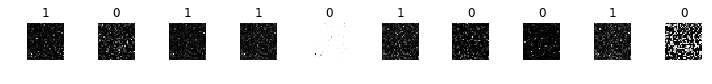

Epoch  201/4000  ||  D acc: 0.53, loss: 0.64  |  G loss: 3.60
Epoch  202/4000  ||  D acc: 0.81, loss: 0.50  |  G loss: 4.12
Epoch  203/4000  ||  D acc: 0.73, loss: 0.52  |  G loss: 3.67
Epoch  204/4000  ||  D acc: 0.70, loss: 0.55  |  G loss: 3.75
Epoch  205/4000  ||  D acc: 0.64, loss: 0.60  |  G loss: 3.91
Epoch  206/4000  ||  D acc: 0.58, loss: 0.64  |  G loss: 3.77
Epoch  207/4000  ||  D acc: 0.70, loss: 0.52  |  G loss: 3.89
Epoch  208/4000  ||  D acc: 0.58, loss: 0.60  |  G loss: 3.22
Epoch  209/4000  ||  D acc: 0.53, loss: 0.63  |  G loss: 4.07
Epoch  210/4000  ||  D acc: 0.70, loss: 0.55  |  G loss: 3.95
Epoch  211/4000  ||  D acc: 0.53, loss: 0.57  |  G loss: 2.75
Epoch  212/4000  ||  D acc: 0.72, loss: 0.58  |  G loss: 3.83
Epoch  213/4000  ||  D acc: 0.59, loss: 0.63  |  G loss: 3.76
Epoch  214/4000  ||  D acc: 0.59, loss: 0.60  |  G loss: 3.53
Epoch  215/4000  ||  D acc: 0.66, loss: 0.55  |  G loss: 3.21
Epoch  216/4000  ||  D acc: 0.69, loss: 0.59  |  G loss: 2.87
Epoch  2

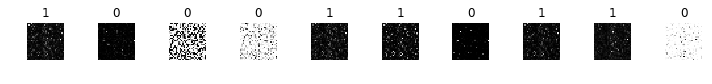

Epoch  251/4000  ||  D acc: 0.45, loss: 0.68  |  G loss: 2.17
Epoch  252/4000  ||  D acc: 0.62, loss: 0.61  |  G loss: 3.22
Epoch  253/4000  ||  D acc: 0.50, loss: 0.65  |  G loss: 3.24
Epoch  254/4000  ||  D acc: 0.62, loss: 0.60  |  G loss: 3.44
Epoch  255/4000  ||  D acc: 0.69, loss: 0.64  |  G loss: 2.71
Epoch  256/4000  ||  D acc: 0.42, loss: 0.63  |  G loss: 3.01
Epoch  257/4000  ||  D acc: 0.58, loss: 0.62  |  G loss: 3.63
Epoch  258/4000  ||  D acc: 0.78, loss: 0.56  |  G loss: 3.35
Epoch  259/4000  ||  D acc: 0.77, loss: 0.54  |  G loss: 2.90
Epoch  260/4000  ||  D acc: 0.78, loss: 0.52  |  G loss: 2.80
Epoch  261/4000  ||  D acc: 0.75, loss: 0.53  |  G loss: 3.06
Epoch  262/4000  ||  D acc: 0.50, loss: 0.65  |  G loss: 2.97
Epoch  263/4000  ||  D acc: 0.67, loss: 0.60  |  G loss: 2.74
Epoch  264/4000  ||  D acc: 0.53, loss: 0.66  |  G loss: 3.51
Epoch  265/4000  ||  D acc: 0.58, loss: 0.66  |  G loss: 2.33
Epoch  266/4000  ||  D acc: 0.80, loss: 0.56  |  G loss: 3.23
Epoch  2

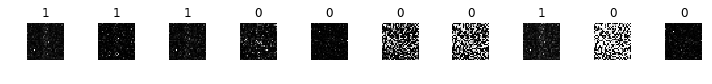

Epoch  301/4000  ||  D acc: 0.75, loss: 0.59  |  G loss: 2.89
Epoch  302/4000  ||  D acc: 0.69, loss: 0.60  |  G loss: 4.24
Epoch  303/4000  ||  D acc: 0.70, loss: 0.60  |  G loss: 2.24
Epoch  304/4000  ||  D acc: 0.84, loss: 0.51  |  G loss: 3.42
Epoch  305/4000  ||  D acc: 0.61, loss: 0.60  |  G loss: 3.53
Epoch  306/4000  ||  D acc: 0.70, loss: 0.58  |  G loss: 3.11
Epoch  307/4000  ||  D acc: 0.81, loss: 0.50  |  G loss: 3.08
Epoch  308/4000  ||  D acc: 0.64, loss: 0.60  |  G loss: 2.31
Epoch  309/4000  ||  D acc: 0.67, loss: 0.62  |  G loss: 3.07
Epoch  310/4000  ||  D acc: 0.78, loss: 0.52  |  G loss: 3.26
Epoch  311/4000  ||  D acc: 0.55, loss: 0.64  |  G loss: 2.79
Epoch  312/4000  ||  D acc: 0.59, loss: 0.60  |  G loss: 2.97
Epoch  313/4000  ||  D acc: 0.78, loss: 0.57  |  G loss: 2.67
Epoch  314/4000  ||  D acc: 0.47, loss: 0.71  |  G loss: 2.34
Epoch  315/4000  ||  D acc: 0.53, loss: 0.65  |  G loss: 2.97
Epoch  316/4000  ||  D acc: 0.56, loss: 0.62  |  G loss: 3.27
Epoch  3

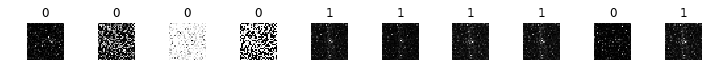

Epoch  351/4000  ||  D acc: 0.56, loss: 0.63  |  G loss: 1.53
Epoch  352/4000  ||  D acc: 0.64, loss: 0.65  |  G loss: 2.74
Epoch  353/4000  ||  D acc: 0.53, loss: 0.64  |  G loss: 2.23
Epoch  354/4000  ||  D acc: 0.69, loss: 0.61  |  G loss: 2.29
Epoch  355/4000  ||  D acc: 0.58, loss: 0.65  |  G loss: 2.24
Epoch  356/4000  ||  D acc: 0.61, loss: 0.62  |  G loss: 2.17
Epoch  357/4000  ||  D acc: 0.62, loss: 0.60  |  G loss: 1.79
Epoch  358/4000  ||  D acc: 0.73, loss: 0.59  |  G loss: 1.64
Epoch  359/4000  ||  D acc: 0.64, loss: 0.61  |  G loss: 2.69
Epoch  360/4000  ||  D acc: 0.70, loss: 0.59  |  G loss: 2.23
Epoch  361/4000  ||  D acc: 0.55, loss: 0.67  |  G loss: 1.81
Epoch  362/4000  ||  D acc: 0.61, loss: 0.64  |  G loss: 1.81
Epoch  363/4000  ||  D acc: 0.44, loss: 0.65  |  G loss: 2.92
Epoch  364/4000  ||  D acc: 0.66, loss: 0.62  |  G loss: 1.94
Epoch  365/4000  ||  D acc: 0.41, loss: 0.67  |  G loss: 2.28
Epoch  366/4000  ||  D acc: 0.64, loss: 0.61  |  G loss: 2.46
Epoch  3

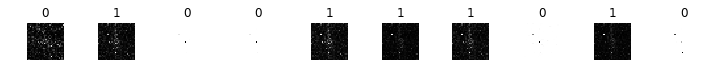

Epoch  401/4000  ||  D acc: 0.45, loss: 0.67  |  G loss: 2.41
Epoch  402/4000  ||  D acc: 0.42, loss: 0.68  |  G loss: 2.44
Epoch  403/4000  ||  D acc: 0.41, loss: 0.72  |  G loss: 1.94
Epoch  404/4000  ||  D acc: 0.50, loss: 0.62  |  G loss: 1.90
Epoch  405/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 2.42
Epoch  406/4000  ||  D acc: 0.56, loss: 0.65  |  G loss: 2.03
Epoch  407/4000  ||  D acc: 0.70, loss: 0.62  |  G loss: 2.43
Epoch  408/4000  ||  D acc: 0.67, loss: 0.60  |  G loss: 2.26
Epoch  409/4000  ||  D acc: 0.72, loss: 0.63  |  G loss: 1.93
Epoch  410/4000  ||  D acc: 0.75, loss: 0.60  |  G loss: 2.40
Epoch  411/4000  ||  D acc: 0.73, loss: 0.55  |  G loss: 1.92
Epoch  412/4000  ||  D acc: 0.61, loss: 0.62  |  G loss: 1.93
Epoch  413/4000  ||  D acc: 0.55, loss: 0.65  |  G loss: 2.18
Epoch  414/4000  ||  D acc: 0.66, loss: 0.66  |  G loss: 2.14
Epoch  415/4000  ||  D acc: 0.66, loss: 0.63  |  G loss: 1.97
Epoch  416/4000  ||  D acc: 0.66, loss: 0.59  |  G loss: 2.20
Epoch  4

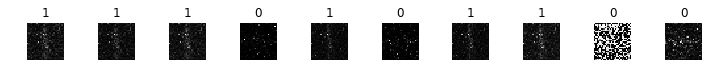

Epoch  451/4000  ||  D acc: 0.56, loss: 0.68  |  G loss: 1.79
Epoch  452/4000  ||  D acc: 0.70, loss: 0.61  |  G loss: 2.39
Epoch  453/4000  ||  D acc: 0.66, loss: 0.62  |  G loss: 1.90
Epoch  454/4000  ||  D acc: 0.72, loss: 0.58  |  G loss: 2.50
Epoch  455/4000  ||  D acc: 0.66, loss: 0.63  |  G loss: 2.12
Epoch  456/4000  ||  D acc: 0.61, loss: 0.60  |  G loss: 1.47
Epoch  457/4000  ||  D acc: 0.67, loss: 0.65  |  G loss: 1.62
Epoch  458/4000  ||  D acc: 0.80, loss: 0.62  |  G loss: 1.77
Epoch  459/4000  ||  D acc: 0.77, loss: 0.60  |  G loss: 2.39
Epoch  460/4000  ||  D acc: 0.41, loss: 0.68  |  G loss: 1.59
Epoch  461/4000  ||  D acc: 0.69, loss: 0.61  |  G loss: 1.63
Epoch  462/4000  ||  D acc: 0.62, loss: 0.59  |  G loss: 2.04
Epoch  463/4000  ||  D acc: 0.62, loss: 0.64  |  G loss: 2.67
Epoch  464/4000  ||  D acc: 0.59, loss: 0.60  |  G loss: 2.53
Epoch  465/4000  ||  D acc: 0.64, loss: 0.63  |  G loss: 1.67
Epoch  466/4000  ||  D acc: 0.73, loss: 0.57  |  G loss: 2.76
Epoch  4

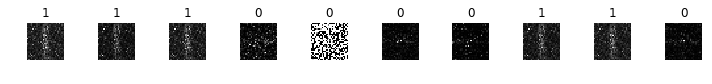

Epoch  501/4000  ||  D acc: 0.66, loss: 0.62  |  G loss: 1.81
Epoch  502/4000  ||  D acc: 0.72, loss: 0.64  |  G loss: 2.74
Epoch  503/4000  ||  D acc: 0.62, loss: 0.64  |  G loss: 2.03
Epoch  504/4000  ||  D acc: 0.53, loss: 0.64  |  G loss: 1.76
Epoch  505/4000  ||  D acc: 0.53, loss: 0.64  |  G loss: 1.79
Epoch  506/4000  ||  D acc: 0.41, loss: 0.69  |  G loss: 1.26
Epoch  507/4000  ||  D acc: 0.58, loss: 0.64  |  G loss: 1.81
Epoch  508/4000  ||  D acc: 0.58, loss: 0.66  |  G loss: 1.66
Epoch  509/4000  ||  D acc: 0.48, loss: 0.65  |  G loss: 2.11
Epoch  510/4000  ||  D acc: 0.44, loss: 0.67  |  G loss: 2.13
Epoch  511/4000  ||  D acc: 0.64, loss: 0.58  |  G loss: 2.15
Epoch  512/4000  ||  D acc: 0.50, loss: 0.68  |  G loss: 2.81
Epoch  513/4000  ||  D acc: 0.48, loss: 0.68  |  G loss: 1.72
Epoch  514/4000  ||  D acc: 0.53, loss: 0.65  |  G loss: 1.43
Epoch  515/4000  ||  D acc: 0.56, loss: 0.66  |  G loss: 1.80
Epoch  516/4000  ||  D acc: 0.56, loss: 0.66  |  G loss: 1.99
Epoch  5

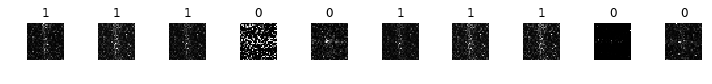

Epoch  551/4000  ||  D acc: 0.61, loss: 0.62  |  G loss: 2.12
Epoch  552/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 1.46
Epoch  553/4000  ||  D acc: 0.56, loss: 0.65  |  G loss: 1.69
Epoch  554/4000  ||  D acc: 0.59, loss: 0.63  |  G loss: 3.04
Epoch  555/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 1.73
Epoch  556/4000  ||  D acc: 0.52, loss: 0.66  |  G loss: 2.22
Epoch  557/4000  ||  D acc: 0.58, loss: 0.64  |  G loss: 2.04
Epoch  558/4000  ||  D acc: 0.70, loss: 0.60  |  G loss: 2.40
Epoch  559/4000  ||  D acc: 0.56, loss: 0.66  |  G loss: 1.49
Epoch  560/4000  ||  D acc: 0.64, loss: 0.65  |  G loss: 2.18
Epoch  561/4000  ||  D acc: 0.39, loss: 0.67  |  G loss: 2.19
Epoch  562/4000  ||  D acc: 0.62, loss: 0.67  |  G loss: 1.51
Epoch  563/4000  ||  D acc: 0.66, loss: 0.63  |  G loss: 2.38
Epoch  564/4000  ||  D acc: 0.66, loss: 0.61  |  G loss: 1.91
Epoch  565/4000  ||  D acc: 0.55, loss: 0.66  |  G loss: 1.53
Epoch  566/4000  ||  D acc: 0.61, loss: 0.68  |  G loss: 2.12
Epoch  5

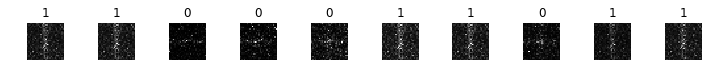

Epoch  601/4000  ||  D acc: 0.61, loss: 0.64  |  G loss: 2.06
Epoch  602/4000  ||  D acc: 0.50, loss: 0.65  |  G loss: 1.69
Epoch  603/4000  ||  D acc: 0.45, loss: 0.68  |  G loss: 1.42
Epoch  604/4000  ||  D acc: 0.55, loss: 0.67  |  G loss: 1.95
Epoch  605/4000  ||  D acc: 0.56, loss: 0.68  |  G loss: 1.85
Epoch  606/4000  ||  D acc: 0.61, loss: 0.65  |  G loss: 1.95
Epoch  607/4000  ||  D acc: 0.39, loss: 0.69  |  G loss: 1.34
Epoch  608/4000  ||  D acc: 0.61, loss: 0.61  |  G loss: 1.26
Epoch  609/4000  ||  D acc: 0.56, loss: 0.64  |  G loss: 1.66
Epoch  610/4000  ||  D acc: 0.53, loss: 0.66  |  G loss: 1.81
Epoch  611/4000  ||  D acc: 0.73, loss: 0.62  |  G loss: 1.58
Epoch  612/4000  ||  D acc: 0.77, loss: 0.59  |  G loss: 1.11
Epoch  613/4000  ||  D acc: 0.64, loss: 0.64  |  G loss: 2.00
Epoch  614/4000  ||  D acc: 0.70, loss: 0.64  |  G loss: 1.58
Epoch  615/4000  ||  D acc: 0.55, loss: 0.63  |  G loss: 1.62
Epoch  616/4000  ||  D acc: 0.44, loss: 0.65  |  G loss: 1.45
Epoch  6

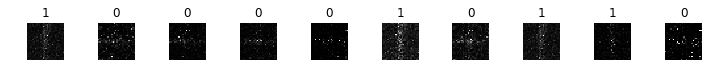

Epoch  651/4000  ||  D acc: 0.62, loss: 0.65  |  G loss: 1.28
Epoch  652/4000  ||  D acc: 0.61, loss: 0.64  |  G loss: 1.25
Epoch  653/4000  ||  D acc: 0.67, loss: 0.64  |  G loss: 1.02
Epoch  654/4000  ||  D acc: 0.48, loss: 0.68  |  G loss: 1.09
Epoch  655/4000  ||  D acc: 0.59, loss: 0.67  |  G loss: 1.44
Epoch  656/4000  ||  D acc: 0.44, loss: 0.68  |  G loss: 1.20
Epoch  657/4000  ||  D acc: 0.66, loss: 0.61  |  G loss: 1.52
Epoch  658/4000  ||  D acc: 0.56, loss: 0.68  |  G loss: 1.16
Epoch  659/4000  ||  D acc: 0.67, loss: 0.64  |  G loss: 1.54
Epoch  660/4000  ||  D acc: 0.66, loss: 0.67  |  G loss: 1.19
Epoch  661/4000  ||  D acc: 0.66, loss: 0.63  |  G loss: 1.34
Epoch  662/4000  ||  D acc: 0.58, loss: 0.69  |  G loss: 1.98
Epoch  663/4000  ||  D acc: 0.66, loss: 0.63  |  G loss: 1.17
Epoch  664/4000  ||  D acc: 0.64, loss: 0.63  |  G loss: 1.09
Epoch  665/4000  ||  D acc: 0.53, loss: 0.65  |  G loss: 1.60
Epoch  666/4000  ||  D acc: 0.50, loss: 0.67  |  G loss: 1.68
Epoch  6

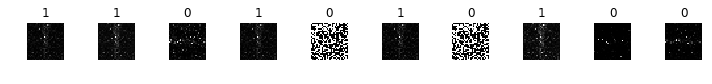

Epoch  701/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 1.15
Epoch  702/4000  ||  D acc: 0.53, loss: 0.68  |  G loss: 1.24
Epoch  703/4000  ||  D acc: 0.55, loss: 0.68  |  G loss: 1.11
Epoch  704/4000  ||  D acc: 0.52, loss: 0.66  |  G loss: 1.03
Epoch  705/4000  ||  D acc: 0.47, loss: 0.68  |  G loss: 0.99
Epoch  706/4000  ||  D acc: 0.50, loss: 0.67  |  G loss: 0.96
Epoch  707/4000  ||  D acc: 0.47, loss: 0.64  |  G loss: 0.97
Epoch  708/4000  ||  D acc: 0.53, loss: 0.67  |  G loss: 0.90
Epoch  709/4000  ||  D acc: 0.58, loss: 0.64  |  G loss: 0.86
Epoch  710/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 1.34
Epoch  711/4000  ||  D acc: 0.62, loss: 0.61  |  G loss: 1.57
Epoch  712/4000  ||  D acc: 0.58, loss: 0.67  |  G loss: 1.00
Epoch  713/4000  ||  D acc: 0.66, loss: 0.64  |  G loss: 1.20
Epoch  714/4000  ||  D acc: 0.66, loss: 0.65  |  G loss: 1.16
Epoch  715/4000  ||  D acc: 0.64, loss: 0.66  |  G loss: 1.19
Epoch  716/4000  ||  D acc: 0.64, loss: 0.63  |  G loss: 1.25
Epoch  7

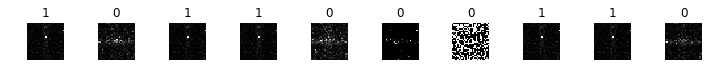

Epoch  751/4000  ||  D acc: 0.47, loss: 0.67  |  G loss: 1.08
Epoch  752/4000  ||  D acc: 0.53, loss: 0.65  |  G loss: 0.95
Epoch  753/4000  ||  D acc: 0.55, loss: 0.65  |  G loss: 0.97
Epoch  754/4000  ||  D acc: 0.53, loss: 0.67  |  G loss: 0.95
Epoch  755/4000  ||  D acc: 0.62, loss: 0.66  |  G loss: 0.96
Epoch  756/4000  ||  D acc: 0.56, loss: 0.63  |  G loss: 1.46
Epoch  757/4000  ||  D acc: 0.61, loss: 0.66  |  G loss: 1.18
Epoch  758/4000  ||  D acc: 0.50, loss: 0.68  |  G loss: 1.05
Epoch  759/4000  ||  D acc: 0.55, loss: 0.68  |  G loss: 0.86
Epoch  760/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 1.03
Epoch  761/4000  ||  D acc: 0.58, loss: 0.67  |  G loss: 1.09
Epoch  762/4000  ||  D acc: 0.47, loss: 0.66  |  G loss: 0.95
Epoch  763/4000  ||  D acc: 0.53, loss: 0.68  |  G loss: 0.90
Epoch  764/4000  ||  D acc: 0.55, loss: 0.66  |  G loss: 1.06
Epoch  765/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.97
Epoch  766/4000  ||  D acc: 0.56, loss: 0.67  |  G loss: 1.25
Epoch  7

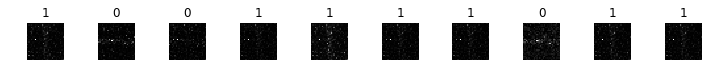

Epoch  801/4000  ||  D acc: 0.47, loss: 0.66  |  G loss: 1.00
Epoch  802/4000  ||  D acc: 0.41, loss: 0.69  |  G loss: 0.87
Epoch  803/4000  ||  D acc: 0.56, loss: 0.66  |  G loss: 1.10
Epoch  804/4000  ||  D acc: 0.47, loss: 0.68  |  G loss: 0.95
Epoch  805/4000  ||  D acc: 0.58, loss: 0.67  |  G loss: 1.10
Epoch  806/4000  ||  D acc: 0.61, loss: 0.67  |  G loss: 0.96
Epoch  807/4000  ||  D acc: 0.42, loss: 0.68  |  G loss: 1.05
Epoch  808/4000  ||  D acc: 0.58, loss: 0.66  |  G loss: 0.95
Epoch  809/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.84
Epoch  810/4000  ||  D acc: 0.53, loss: 0.67  |  G loss: 0.86
Epoch  811/4000  ||  D acc: 0.62, loss: 0.67  |  G loss: 1.07
Epoch  812/4000  ||  D acc: 0.64, loss: 0.62  |  G loss: 1.03
Epoch  813/4000  ||  D acc: 0.41, loss: 0.67  |  G loss: 1.06
Epoch  814/4000  ||  D acc: 0.55, loss: 0.64  |  G loss: 1.01
Epoch  815/4000  ||  D acc: 0.66, loss: 0.67  |  G loss: 0.99
Epoch  816/4000  ||  D acc: 0.45, loss: 0.68  |  G loss: 1.04
Epoch  8

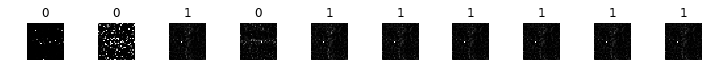

Epoch  851/4000  ||  D acc: 0.50, loss: 0.68  |  G loss: 0.96
Epoch  852/4000  ||  D acc: 0.56, loss: 0.67  |  G loss: 1.04
Epoch  853/4000  ||  D acc: 0.56, loss: 0.67  |  G loss: 1.00
Epoch  854/4000  ||  D acc: 0.50, loss: 0.68  |  G loss: 1.00
Epoch  855/4000  ||  D acc: 0.48, loss: 0.66  |  G loss: 0.92
Epoch  856/4000  ||  D acc: 0.58, loss: 0.66  |  G loss: 0.81
Epoch  857/4000  ||  D acc: 0.53, loss: 0.70  |  G loss: 0.95
Epoch  858/4000  ||  D acc: 0.62, loss: 0.67  |  G loss: 1.04
Epoch  859/4000  ||  D acc: 0.55, loss: 0.68  |  G loss: 0.87
Epoch  860/4000  ||  D acc: 0.53, loss: 0.66  |  G loss: 0.96
Epoch  861/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 1.31
Epoch  862/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.90
Epoch  863/4000  ||  D acc: 0.39, loss: 0.68  |  G loss: 0.91
Epoch  864/4000  ||  D acc: 0.42, loss: 0.71  |  G loss: 0.83
Epoch  865/4000  ||  D acc: 0.52, loss: 0.68  |  G loss: 0.88
Epoch  866/4000  ||  D acc: 0.59, loss: 0.62  |  G loss: 0.92
Epoch  8

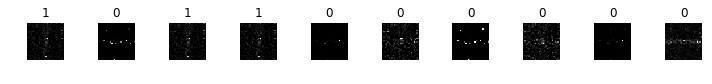

Epoch  901/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.72
Epoch  902/4000  ||  D acc: 0.62, loss: 0.67  |  G loss: 0.85
Epoch  903/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.74
Epoch  904/4000  ||  D acc: 0.52, loss: 0.70  |  G loss: 0.71
Epoch  905/4000  ||  D acc: 0.61, loss: 0.68  |  G loss: 0.73
Epoch  906/4000  ||  D acc: 0.52, loss: 0.70  |  G loss: 0.73
Epoch  907/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.73
Epoch  908/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.73
Epoch  909/4000  ||  D acc: 0.50, loss: 0.71  |  G loss: 0.72
Epoch  910/4000  ||  D acc: 0.47, loss: 0.68  |  G loss: 0.73
Epoch  911/4000  ||  D acc: 0.53, loss: 0.69  |  G loss: 0.76
Epoch  912/4000  ||  D acc: 0.42, loss: 0.71  |  G loss: 0.75
Epoch  913/4000  ||  D acc: 0.56, loss: 0.69  |  G loss: 0.76
Epoch  914/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.79
Epoch  915/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.73
Epoch  916/4000  ||  D acc: 0.50, loss: 0.70  |  G loss: 0.79
Epoch  9

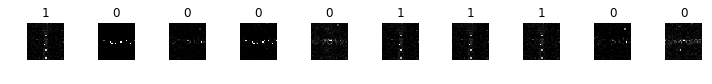

Epoch  951/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.72
Epoch  952/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.75
Epoch  953/4000  ||  D acc: 0.36, loss: 0.71  |  G loss: 0.74
Epoch  954/4000  ||  D acc: 0.48, loss: 0.70  |  G loss: 0.72
Epoch  955/4000  ||  D acc: 0.38, loss: 0.71  |  G loss: 0.72
Epoch  956/4000  ||  D acc: 0.53, loss: 0.70  |  G loss: 0.71
Epoch  957/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.73
Epoch  958/4000  ||  D acc: 0.50, loss: 0.70  |  G loss: 0.78
Epoch  959/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch  960/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch  961/4000  ||  D acc: 0.66, loss: 0.68  |  G loss: 0.70
Epoch  962/4000  ||  D acc: 0.52, loss: 0.70  |  G loss: 0.72
Epoch  963/4000  ||  D acc: 0.48, loss: 0.68  |  G loss: 0.71
Epoch  964/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.72
Epoch  965/4000  ||  D acc: 0.42, loss: 0.71  |  G loss: 0.73
Epoch  966/4000  ||  D acc: 0.34, loss: 0.71  |  G loss: 0.73
Epoch  9

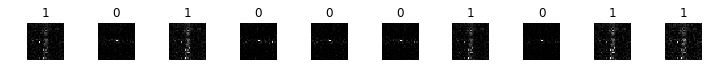

Epoch 1001/4000  ||  D acc: 0.48, loss: 0.70  |  G loss: 0.71
Epoch 1002/4000  ||  D acc: 0.47, loss: 0.70  |  G loss: 0.72
Epoch 1003/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.71
Epoch 1004/4000  ||  D acc: 0.47, loss: 0.70  |  G loss: 0.73
Epoch 1005/4000  ||  D acc: 0.55, loss: 0.69  |  G loss: 0.71
Epoch 1006/4000  ||  D acc: 0.50, loss: 0.70  |  G loss: 0.71
Epoch 1007/4000  ||  D acc: 0.45, loss: 0.68  |  G loss: 0.72
Epoch 1008/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 1009/4000  ||  D acc: 0.50, loss: 0.70  |  G loss: 0.70
Epoch 1010/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.71
Epoch 1011/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.71
Epoch 1012/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.71
Epoch 1013/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.72
Epoch 1014/4000  ||  D acc: 0.55, loss: 0.66  |  G loss: 0.71
Epoch 1015/4000  ||  D acc: 0.47, loss: 0.70  |  G loss: 0.71
Epoch 1016/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.72
Epoch 10

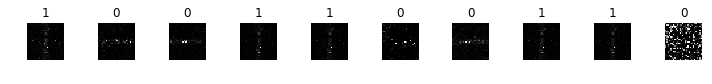

Epoch 1051/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.72
Epoch 1052/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 1053/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 1054/4000  ||  D acc: 0.41, loss: 0.69  |  G loss: 0.70
Epoch 1055/4000  ||  D acc: 0.48, loss: 0.70  |  G loss: 0.70
Epoch 1056/4000  ||  D acc: 0.47, loss: 0.70  |  G loss: 0.71
Epoch 1057/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 1058/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.71
Epoch 1059/4000  ||  D acc: 0.47, loss: 0.70  |  G loss: 0.70
Epoch 1060/4000  ||  D acc: 0.33, loss: 0.71  |  G loss: 0.69
Epoch 1061/4000  ||  D acc: 0.33, loss: 0.70  |  G loss: 0.71
Epoch 1062/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 1063/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.70
Epoch 1064/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.69
Epoch 1065/4000  ||  D acc: 0.53, loss: 0.69  |  G loss: 0.70
Epoch 1066/4000  ||  D acc: 0.50, loss: 0.70  |  G loss: 0.70
Epoch 10

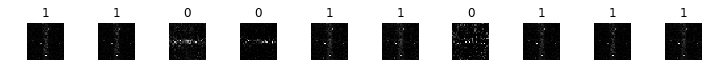

Epoch 1101/4000  ||  D acc: 0.28, loss: 0.70  |  G loss: 0.70
Epoch 1102/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.69
Epoch 1103/4000  ||  D acc: 0.47, loss: 0.68  |  G loss: 0.69
Epoch 1104/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.69
Epoch 1105/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 1106/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 1107/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 1108/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.71
Epoch 1109/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 1110/4000  ||  D acc: 0.47, loss: 0.70  |  G loss: 0.70
Epoch 1111/4000  ||  D acc: 0.39, loss: 0.69  |  G loss: 0.70
Epoch 1112/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 1113/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 1114/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 1115/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 1116/4000  ||  D acc: 0.56, loss: 0.69  |  G loss: 0.70
Epoch 11

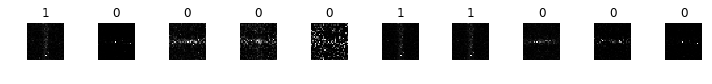

Epoch 1151/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.69
Epoch 1152/4000  ||  D acc: 0.50, loss: 0.70  |  G loss: 0.70
Epoch 1153/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.69
Epoch 1154/4000  ||  D acc: 0.50, loss: 0.70  |  G loss: 0.70
Epoch 1155/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 1156/4000  ||  D acc: 0.48, loss: 0.70  |  G loss: 0.70
Epoch 1157/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.70
Epoch 1158/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 1159/4000  ||  D acc: 0.39, loss: 0.69  |  G loss: 0.70
Epoch 1160/4000  ||  D acc: 0.53, loss: 0.69  |  G loss: 0.72
Epoch 1161/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 1162/4000  ||  D acc: 0.47, loss: 0.70  |  G loss: 0.70
Epoch 1163/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 1164/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.69
Epoch 1165/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.69
Epoch 1166/4000  ||  D acc: 0.47, loss: 0.70  |  G loss: 0.70
Epoch 11

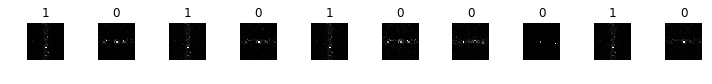

Epoch 1201/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 1202/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 1203/4000  ||  D acc: 0.48, loss: 0.70  |  G loss: 0.70
Epoch 1204/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 1205/4000  ||  D acc: 0.33, loss: 0.70  |  G loss: 0.69
Epoch 1206/4000  ||  D acc: 0.53, loss: 0.69  |  G loss: 0.70
Epoch 1207/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 1208/4000  ||  D acc: 0.55, loss: 0.68  |  G loss: 0.69
Epoch 1209/4000  ||  D acc: 0.47, loss: 0.70  |  G loss: 0.70
Epoch 1210/4000  ||  D acc: 0.41, loss: 0.69  |  G loss: 0.70
Epoch 1211/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 1212/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 1213/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 1214/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.71
Epoch 1215/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 1216/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 12

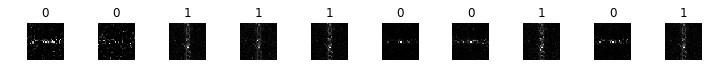

Epoch 1251/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 1252/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 1253/4000  ||  D acc: 0.55, loss: 0.69  |  G loss: 0.70
Epoch 1254/4000  ||  D acc: 0.34, loss: 0.70  |  G loss: 0.70
Epoch 1255/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 1256/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.71
Epoch 1257/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.71
Epoch 1258/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 1259/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 1260/4000  ||  D acc: 0.52, loss: 0.68  |  G loss: 0.70
Epoch 1261/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.71
Epoch 1262/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 1263/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.74
Epoch 1264/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 1265/4000  ||  D acc: 0.53, loss: 0.69  |  G loss: 0.70
Epoch 1266/4000  ||  D acc: 0.48, loss: 0.70  |  G loss: 0.71
Epoch 12

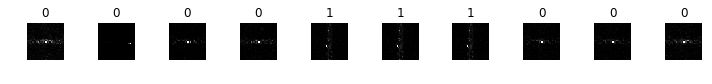

Epoch 1301/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 1302/4000  ||  D acc: 0.52, loss: 0.70  |  G loss: 0.71
Epoch 1303/4000  ||  D acc: 0.50, loss: 0.70  |  G loss: 0.70
Epoch 1304/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.69
Epoch 1305/4000  ||  D acc: 0.53, loss: 0.69  |  G loss: 0.70
Epoch 1306/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.71
Epoch 1307/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.71
Epoch 1308/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 1309/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 1310/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.71
Epoch 1311/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 1312/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 1313/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 1314/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 1315/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 1316/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 13

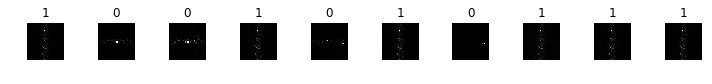

Epoch 1351/4000  ||  D acc: 0.47, loss: 0.70  |  G loss: 0.71
Epoch 1352/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 1353/4000  ||  D acc: 0.33, loss: 0.70  |  G loss: 0.71
Epoch 1354/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 1355/4000  ||  D acc: 0.41, loss: 0.69  |  G loss: 0.70
Epoch 1356/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.71
Epoch 1357/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.71
Epoch 1358/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 1359/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 1360/4000  ||  D acc: 0.48, loss: 0.70  |  G loss: 0.70
Epoch 1361/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 1362/4000  ||  D acc: 0.50, loss: 0.70  |  G loss: 0.70
Epoch 1363/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 1364/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.71
Epoch 1365/4000  ||  D acc: 0.48, loss: 0.70  |  G loss: 0.70
Epoch 1366/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.71
Epoch 13

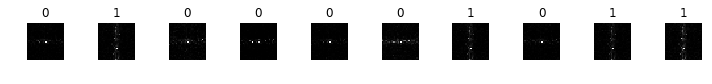

Epoch 1401/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.71
Epoch 1402/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 1403/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.71
Epoch 1404/4000  ||  D acc: 0.39, loss: 0.69  |  G loss: 0.70
Epoch 1405/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.71
Epoch 1406/4000  ||  D acc: 0.34, loss: 0.70  |  G loss: 0.71
Epoch 1407/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 1408/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 1409/4000  ||  D acc: 0.48, loss: 0.70  |  G loss: 0.70
Epoch 1410/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 1411/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.71
Epoch 1412/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 1413/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 1414/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 1415/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 1416/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 14

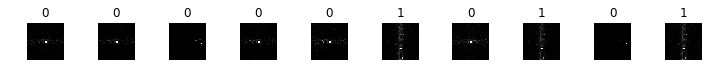

Epoch 1451/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 1452/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 1453/4000  ||  D acc: 0.41, loss: 0.69  |  G loss: 0.70
Epoch 1454/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 1455/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 1456/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 1457/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 1458/4000  ||  D acc: 0.41, loss: 0.69  |  G loss: 0.70
Epoch 1459/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 1460/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 1461/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 1462/4000  ||  D acc: 0.34, loss: 0.70  |  G loss: 0.70
Epoch 1463/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 1464/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.69
Epoch 1465/4000  ||  D acc: 0.34, loss: 0.70  |  G loss: 0.69
Epoch 1466/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 14

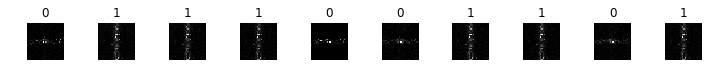

Epoch 1501/4000  ||  D acc: 0.38, loss: 0.69  |  G loss: 0.70
Epoch 1502/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 1503/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 1504/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.69
Epoch 1505/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 1506/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 1507/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.70
Epoch 1508/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.70
Epoch 1509/4000  ||  D acc: 0.34, loss: 0.70  |  G loss: 0.70
Epoch 1510/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 1511/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 1512/4000  ||  D acc: 0.31, loss: 0.70  |  G loss: 0.70
Epoch 1513/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 1514/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 1515/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 1516/4000  ||  D acc: 0.39, loss: 0.69  |  G loss: 0.70
Epoch 15

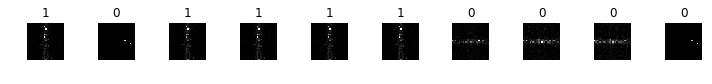

Epoch 1551/4000  ||  D acc: 0.33, loss: 0.70  |  G loss: 0.70
Epoch 1552/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 1553/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 1554/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 1555/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 1556/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 1557/4000  ||  D acc: 0.48, loss: 0.70  |  G loss: 0.71
Epoch 1558/4000  ||  D acc: 0.58, loss: 0.68  |  G loss: 0.70
Epoch 1559/4000  ||  D acc: 0.47, loss: 0.70  |  G loss: 0.71
Epoch 1560/4000  ||  D acc: 0.53, loss: 0.69  |  G loss: 0.70
Epoch 1561/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 1562/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 1563/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 1564/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 1565/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 1566/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 15

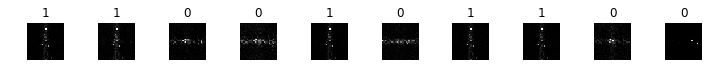

Epoch 1601/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.71
Epoch 1602/4000  ||  D acc: 0.33, loss: 0.70  |  G loss: 0.71
Epoch 1603/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 1604/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 1605/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 1606/4000  ||  D acc: 0.33, loss: 0.70  |  G loss: 0.70
Epoch 1607/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.71
Epoch 1608/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.71
Epoch 1609/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 1610/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 1611/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 1612/4000  ||  D acc: 0.31, loss: 0.70  |  G loss: 0.71
Epoch 1613/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 1614/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 1615/4000  ||  D acc: 0.47, loss: 0.70  |  G loss: 0.70
Epoch 1616/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 16

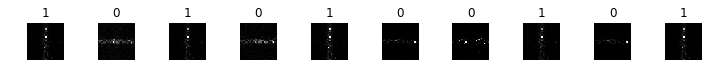

Epoch 1651/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 1652/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 1653/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.70
Epoch 1654/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 1655/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.71
Epoch 1656/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 1657/4000  ||  D acc: 0.47, loss: 0.67  |  G loss: 0.70
Epoch 1658/4000  ||  D acc: 0.30, loss: 0.70  |  G loss: 0.70
Epoch 1659/4000  ||  D acc: 0.33, loss: 0.70  |  G loss: 0.70
Epoch 1660/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 1661/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.70
Epoch 1662/4000  ||  D acc: 0.39, loss: 0.69  |  G loss: 0.70
Epoch 1663/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.70
Epoch 1664/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 1665/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 1666/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 16

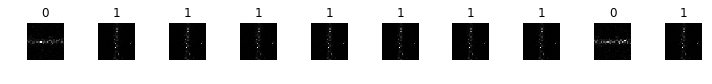

Epoch 1701/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 1702/4000  ||  D acc: 0.47, loss: 0.70  |  G loss: 0.70
Epoch 1703/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 1704/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 1705/4000  ||  D acc: 0.56, loss: 0.69  |  G loss: 0.70
Epoch 1706/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.71
Epoch 1707/4000  ||  D acc: 0.41, loss: 0.69  |  G loss: 0.70
Epoch 1708/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 1709/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 1710/4000  ||  D acc: 0.30, loss: 0.70  |  G loss: 0.70
Epoch 1711/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 1712/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 1713/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 1714/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 1715/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 1716/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 17

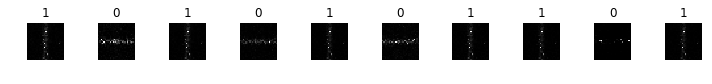

Epoch 1751/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 1752/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 1753/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.71
Epoch 1754/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 1755/4000  ||  D acc: 0.41, loss: 0.69  |  G loss: 0.70
Epoch 1756/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 1757/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 1758/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 1759/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 1760/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 1761/4000  ||  D acc: 0.33, loss: 0.70  |  G loss: 0.70
Epoch 1762/4000  ||  D acc: 0.41, loss: 0.69  |  G loss: 0.70
Epoch 1763/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.71
Epoch 1764/4000  ||  D acc: 0.58, loss: 0.69  |  G loss: 0.70
Epoch 1765/4000  ||  D acc: 0.52, loss: 0.70  |  G loss: 0.70
Epoch 1766/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 17

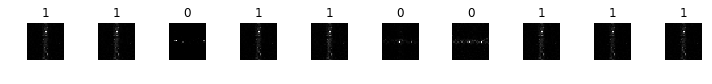

Epoch 1801/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 1802/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 1803/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 1804/4000  ||  D acc: 0.42, loss: 0.68  |  G loss: 0.70
Epoch 1805/4000  ||  D acc: 0.34, loss: 0.70  |  G loss: 0.70
Epoch 1806/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 1807/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 1808/4000  ||  D acc: 0.47, loss: 0.66  |  G loss: 0.70
Epoch 1809/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.69
Epoch 1810/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 1811/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 1812/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 1813/4000  ||  D acc: 0.34, loss: 0.69  |  G loss: 0.71
Epoch 1814/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 1815/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 1816/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 18

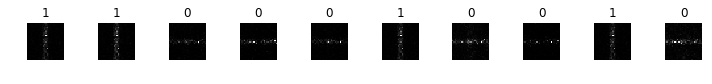

Epoch 1851/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 1852/4000  ||  D acc: 0.48, loss: 0.70  |  G loss: 0.70
Epoch 1853/4000  ||  D acc: 0.53, loss: 0.69  |  G loss: 0.70
Epoch 1854/4000  ||  D acc: 0.33, loss: 0.70  |  G loss: 0.70
Epoch 1855/4000  ||  D acc: 0.53, loss: 0.69  |  G loss: 0.70
Epoch 1856/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 1857/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 1858/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 1859/4000  ||  D acc: 0.42, loss: 0.68  |  G loss: 0.69
Epoch 1860/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 1861/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 1862/4000  ||  D acc: 0.55, loss: 0.69  |  G loss: 0.70
Epoch 1863/4000  ||  D acc: 0.28, loss: 0.70  |  G loss: 0.69
Epoch 1864/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.69
Epoch 1865/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 1866/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 18

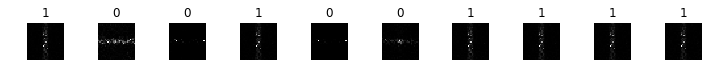

Epoch 1901/4000  ||  D acc: 0.22, loss: 0.70  |  G loss: 0.70
Epoch 1902/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.70
Epoch 1903/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 1904/4000  ||  D acc: 0.34, loss: 0.70  |  G loss: 0.70
Epoch 1905/4000  ||  D acc: 0.41, loss: 0.69  |  G loss: 0.70
Epoch 1906/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 1907/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 1908/4000  ||  D acc: 0.34, loss: 0.70  |  G loss: 0.70
Epoch 1909/4000  ||  D acc: 0.34, loss: 0.70  |  G loss: 0.70
Epoch 1910/4000  ||  D acc: 0.34, loss: 0.70  |  G loss: 0.70
Epoch 1911/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 1912/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 1913/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.71
Epoch 1914/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 1915/4000  ||  D acc: 0.36, loss: 0.69  |  G loss: 0.70
Epoch 1916/4000  ||  D acc: 0.34, loss: 0.70  |  G loss: 0.70
Epoch 19

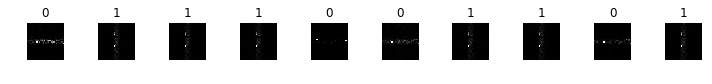

Epoch 1951/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 1952/4000  ||  D acc: 0.47, loss: 0.70  |  G loss: 0.70
Epoch 1953/4000  ||  D acc: 0.53, loss: 0.69  |  G loss: 0.70
Epoch 1954/4000  ||  D acc: 0.33, loss: 0.70  |  G loss: 0.70
Epoch 1955/4000  ||  D acc: 0.48, loss: 0.68  |  G loss: 0.70
Epoch 1956/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 1957/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 1958/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 1959/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 1960/4000  ||  D acc: 0.34, loss: 0.70  |  G loss: 0.70
Epoch 1961/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 1962/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.71
Epoch 1963/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 1964/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 1965/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 1966/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 19

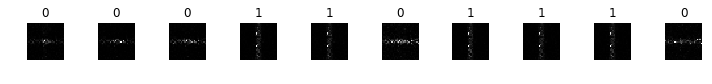

Epoch 2001/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 2002/4000  ||  D acc: 0.50, loss: 0.70  |  G loss: 0.70
Epoch 2003/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 2004/4000  ||  D acc: 0.31, loss: 0.70  |  G loss: 0.71
Epoch 2005/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 2006/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 2007/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.70
Epoch 2008/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 2009/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 2010/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 2011/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 2012/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.71
Epoch 2013/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.71
Epoch 2014/4000  ||  D acc: 0.28, loss: 0.70  |  G loss: 0.70
Epoch 2015/4000  ||  D acc: 0.55, loss: 0.69  |  G loss: 0.70
Epoch 2016/4000  ||  D acc: 0.55, loss: 0.69  |  G loss: 0.70
Epoch 20

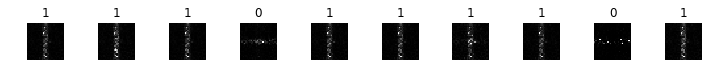

Epoch 2051/4000  ||  D acc: 0.31, loss: 0.70  |  G loss: 0.70
Epoch 2052/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 2053/4000  ||  D acc: 0.50, loss: 0.70  |  G loss: 0.70
Epoch 2054/4000  ||  D acc: 0.45, loss: 0.68  |  G loss: 0.70
Epoch 2055/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 2056/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 2057/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 2058/4000  ||  D acc: 0.38, loss: 0.69  |  G loss: 0.70
Epoch 2059/4000  ||  D acc: 0.42, loss: 0.68  |  G loss: 0.71
Epoch 2060/4000  ||  D acc: 0.33, loss: 0.70  |  G loss: 0.70
Epoch 2061/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 2062/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 2063/4000  ||  D acc: 0.39, loss: 0.69  |  G loss: 0.70
Epoch 2064/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 2065/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 2066/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.70
Epoch 20

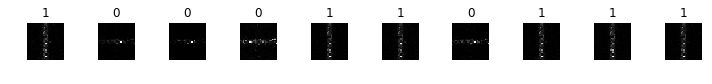

Epoch 2101/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 2102/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 2103/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 2104/4000  ||  D acc: 0.34, loss: 0.70  |  G loss: 0.70
Epoch 2105/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 2106/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 2107/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 2108/4000  ||  D acc: 0.48, loss: 0.68  |  G loss: 0.70
Epoch 2109/4000  ||  D acc: 0.34, loss: 0.70  |  G loss: 0.70
Epoch 2110/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 2111/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 2112/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 2113/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 2114/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 2115/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 2116/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 21

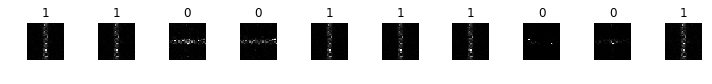

Epoch 2151/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 2152/4000  ||  D acc: 0.39, loss: 0.69  |  G loss: 0.70
Epoch 2153/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 2154/4000  ||  D acc: 0.28, loss: 0.70  |  G loss: 0.70
Epoch 2155/4000  ||  D acc: 0.55, loss: 0.69  |  G loss: 0.70
Epoch 2156/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 2157/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.70
Epoch 2158/4000  ||  D acc: 0.50, loss: 0.70  |  G loss: 0.70
Epoch 2159/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 2160/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 2161/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 2162/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 2163/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 2164/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 2165/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.71
Epoch 2166/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 21

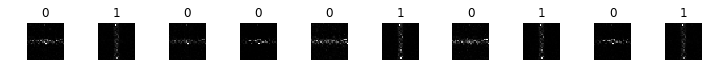

Epoch 2201/4000  ||  D acc: 0.41, loss: 0.69  |  G loss: 0.70
Epoch 2202/4000  ||  D acc: 0.47, loss: 0.70  |  G loss: 0.70
Epoch 2203/4000  ||  D acc: 0.31, loss: 0.70  |  G loss: 0.70
Epoch 2204/4000  ||  D acc: 0.33, loss: 0.70  |  G loss: 0.70
Epoch 2205/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 2206/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 2207/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 2208/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 2209/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 2210/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 2211/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 2212/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.71
Epoch 2213/4000  ||  D acc: 0.31, loss: 0.70  |  G loss: 0.70
Epoch 2214/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 2215/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 2216/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.70
Epoch 22

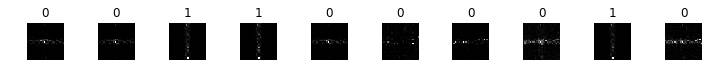

Epoch 2251/4000  ||  D acc: 0.39, loss: 0.68  |  G loss: 0.70
Epoch 2252/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 2253/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 2254/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 2255/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 2256/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 2257/4000  ||  D acc: 0.25, loss: 0.70  |  G loss: 0.70
Epoch 2258/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 2259/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 2260/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 2261/4000  ||  D acc: 0.33, loss: 0.70  |  G loss: 0.70
Epoch 2262/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.71
Epoch 2263/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 2264/4000  ||  D acc: 0.41, loss: 0.69  |  G loss: 0.71
Epoch 2265/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.71
Epoch 2266/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 22

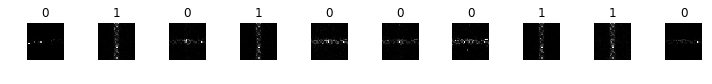

Epoch 2301/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.71
Epoch 2302/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.70
Epoch 2303/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 2304/4000  ||  D acc: 0.31, loss: 0.69  |  G loss: 0.70
Epoch 2305/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.71
Epoch 2306/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 2307/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 2308/4000  ||  D acc: 0.41, loss: 0.67  |  G loss: 0.70
Epoch 2309/4000  ||  D acc: 0.34, loss: 0.70  |  G loss: 0.70
Epoch 2310/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 2311/4000  ||  D acc: 0.55, loss: 0.69  |  G loss: 0.70
Epoch 2312/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.71
Epoch 2313/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 2314/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 2315/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 2316/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.70
Epoch 23

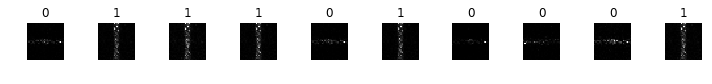

Epoch 2351/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.69
Epoch 2352/4000  ||  D acc: 0.55, loss: 0.69  |  G loss: 0.70
Epoch 2353/4000  ||  D acc: 0.48, loss: 0.70  |  G loss: 0.70
Epoch 2354/4000  ||  D acc: 0.30, loss: 0.70  |  G loss: 0.69
Epoch 2355/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 2356/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 2357/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 2358/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 2359/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.69
Epoch 2360/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 2361/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 2362/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 2363/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 2364/4000  ||  D acc: 0.53, loss: 0.69  |  G loss: 0.70
Epoch 2365/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 2366/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.69
Epoch 23

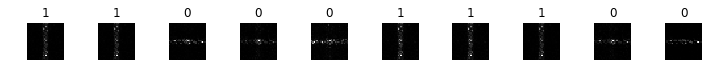

Epoch 2401/4000  ||  D acc: 0.31, loss: 0.70  |  G loss: 0.70
Epoch 2402/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 2403/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 2404/4000  ||  D acc: 0.30, loss: 0.70  |  G loss: 0.70
Epoch 2405/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 2406/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 2407/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 2408/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 2409/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 2410/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 2411/4000  ||  D acc: 0.50, loss: 0.70  |  G loss: 0.70
Epoch 2412/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 2413/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 2414/4000  ||  D acc: 0.41, loss: 0.69  |  G loss: 0.70
Epoch 2415/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 2416/4000  ||  D acc: 0.25, loss: 0.70  |  G loss: 0.70
Epoch 24

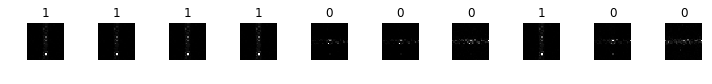

Epoch 2451/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 2452/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 2453/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 2454/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 2455/4000  ||  D acc: 0.41, loss: 0.69  |  G loss: 0.70
Epoch 2456/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.70
Epoch 2457/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 2458/4000  ||  D acc: 0.34, loss: 0.70  |  G loss: 0.70
Epoch 2459/4000  ||  D acc: 0.31, loss: 0.70  |  G loss: 0.70
Epoch 2460/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 2461/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 2462/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.70
Epoch 2463/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.71
Epoch 2464/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 2465/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 2466/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 24

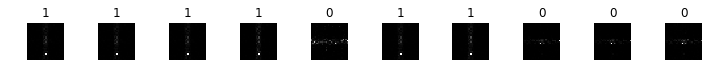

Epoch 2501/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 2502/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 2503/4000  ||  D acc: 0.55, loss: 0.69  |  G loss: 0.70
Epoch 2504/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 2505/4000  ||  D acc: 0.50, loss: 0.70  |  G loss: 0.70
Epoch 2506/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 2507/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 2508/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 2509/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.71
Epoch 2510/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 2511/4000  ||  D acc: 0.53, loss: 0.69  |  G loss: 0.70
Epoch 2512/4000  ||  D acc: 0.55, loss: 0.69  |  G loss: 0.70
Epoch 2513/4000  ||  D acc: 0.55, loss: 0.69  |  G loss: 0.70
Epoch 2514/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 2515/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 2516/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 25

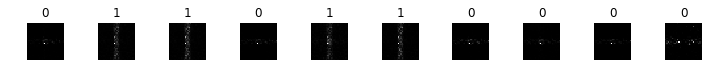

Epoch 2551/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 2552/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 2553/4000  ||  D acc: 0.33, loss: 0.70  |  G loss: 0.70
Epoch 2554/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 2555/4000  ||  D acc: 0.34, loss: 0.70  |  G loss: 0.70
Epoch 2556/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 2557/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 2558/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 2559/4000  ||  D acc: 0.33, loss: 0.70  |  G loss: 0.70
Epoch 2560/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.71
Epoch 2561/4000  ||  D acc: 0.31, loss: 0.70  |  G loss: 0.70
Epoch 2562/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 2563/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 2564/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 2565/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 2566/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.70
Epoch 25

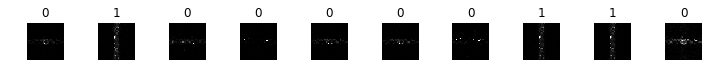

Epoch 2601/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 2602/4000  ||  D acc: 0.41, loss: 0.69  |  G loss: 0.70
Epoch 2603/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 2604/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 2605/4000  ||  D acc: 0.53, loss: 0.68  |  G loss: 0.70
Epoch 2606/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 2607/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 2608/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 2609/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 2610/4000  ||  D acc: 0.48, loss: 0.70  |  G loss: 0.70
Epoch 2611/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 2612/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 2613/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 2614/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 2615/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.70
Epoch 2616/4000  ||  D acc: 0.48, loss: 0.70  |  G loss: 0.70
Epoch 26

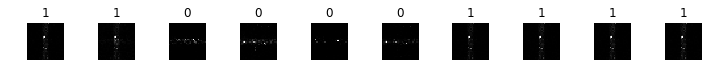

Epoch 2651/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 2652/4000  ||  D acc: 0.50, loss: 0.70  |  G loss: 0.70
Epoch 2653/4000  ||  D acc: 0.39, loss: 0.69  |  G loss: 0.70
Epoch 2654/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 2655/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 2656/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 2657/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 2658/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 2659/4000  ||  D acc: 0.47, loss: 0.68  |  G loss: 0.70
Epoch 2660/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 2661/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 2662/4000  ||  D acc: 0.31, loss: 0.70  |  G loss: 0.70
Epoch 2663/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 2664/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 2665/4000  ||  D acc: 0.34, loss: 0.70  |  G loss: 0.70
Epoch 2666/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 26

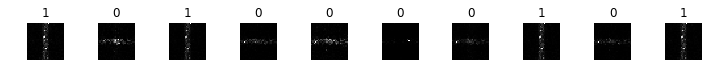

Epoch 2701/4000  ||  D acc: 0.36, loss: 0.69  |  G loss: 0.70
Epoch 2702/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 2703/4000  ||  D acc: 0.41, loss: 0.68  |  G loss: 0.70
Epoch 2704/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 2705/4000  ||  D acc: 0.39, loss: 0.69  |  G loss: 0.70
Epoch 2706/4000  ||  D acc: 0.55, loss: 0.69  |  G loss: 0.70
Epoch 2707/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 2708/4000  ||  D acc: 0.55, loss: 0.69  |  G loss: 0.70
Epoch 2709/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 2710/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 2711/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 2712/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 2713/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.71
Epoch 2714/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 2715/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 2716/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 27

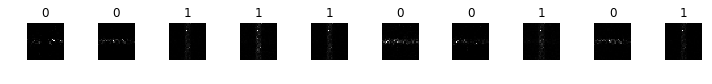

Epoch 2751/4000  ||  D acc: 0.33, loss: 0.70  |  G loss: 0.70
Epoch 2752/4000  ||  D acc: 0.34, loss: 0.70  |  G loss: 0.70
Epoch 2753/4000  ||  D acc: 0.39, loss: 0.69  |  G loss: 0.70
Epoch 2754/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 2755/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 2756/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 2757/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.71
Epoch 2758/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 2759/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 2760/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 2761/4000  ||  D acc: 0.41, loss: 0.69  |  G loss: 0.71
Epoch 2762/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.71
Epoch 2763/4000  ||  D acc: 0.50, loss: 0.70  |  G loss: 0.70
Epoch 2764/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 2765/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 2766/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 27

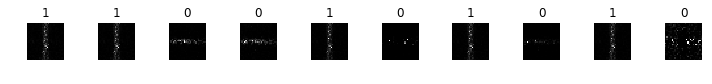

Epoch 2801/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 2802/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 2803/4000  ||  D acc: 0.33, loss: 0.70  |  G loss: 0.70
Epoch 2804/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 2805/4000  ||  D acc: 0.44, loss: 0.68  |  G loss: 0.70
Epoch 2806/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 2807/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 2808/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 2809/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 2810/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 2811/4000  ||  D acc: 0.30, loss: 0.70  |  G loss: 0.70
Epoch 2812/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 2813/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 2814/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 2815/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 2816/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 28

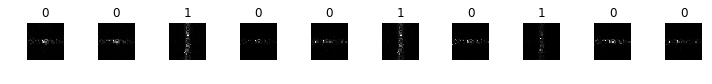

Epoch 2851/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.69
Epoch 2852/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.69
Epoch 2853/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.69
Epoch 2854/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.69
Epoch 2855/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.69
Epoch 2856/4000  ||  D acc: 0.53, loss: 0.70  |  G loss: 0.70
Epoch 2857/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.69
Epoch 2858/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.69
Epoch 2859/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.69
Epoch 2860/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 2861/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.69
Epoch 2862/4000  ||  D acc: 0.47, loss: 0.70  |  G loss: 0.69
Epoch 2863/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.70
Epoch 2864/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.69
Epoch 2865/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.69
Epoch 2866/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 28

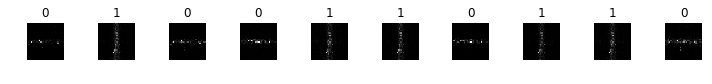

Epoch 2901/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 2902/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 2903/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 2904/4000  ||  D acc: 0.39, loss: 0.69  |  G loss: 0.70
Epoch 2905/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 2906/4000  ||  D acc: 0.31, loss: 0.70  |  G loss: 0.70
Epoch 2907/4000  ||  D acc: 0.33, loss: 0.70  |  G loss: 0.70
Epoch 2908/4000  ||  D acc: 0.34, loss: 0.70  |  G loss: 0.70
Epoch 2909/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 2910/4000  ||  D acc: 0.53, loss: 0.69  |  G loss: 0.70
Epoch 2911/4000  ||  D acc: 0.53, loss: 0.69  |  G loss: 0.70
Epoch 2912/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 2913/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 2914/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 2915/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 2916/4000  ||  D acc: 0.36, loss: 0.69  |  G loss: 0.70
Epoch 29

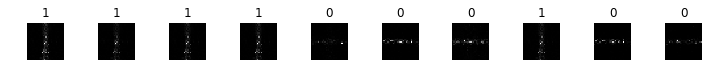

Epoch 2951/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.71
Epoch 2952/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 2953/4000  ||  D acc: 0.53, loss: 0.69  |  G loss: 0.70
Epoch 2954/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 2955/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 2956/4000  ||  D acc: 0.41, loss: 0.69  |  G loss: 0.70
Epoch 2957/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 2958/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 2959/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 2960/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 2961/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 2962/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.71
Epoch 2963/4000  ||  D acc: 0.47, loss: 0.70  |  G loss: 0.70
Epoch 2964/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.71
Epoch 2965/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 2966/4000  ||  D acc: 0.53, loss: 0.69  |  G loss: 0.71
Epoch 29

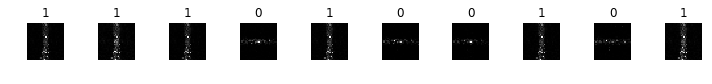

Epoch 3001/4000  ||  D acc: 0.47, loss: 0.70  |  G loss: 0.70
Epoch 3002/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.71
Epoch 3003/4000  ||  D acc: 0.48, loss: 0.70  |  G loss: 0.70
Epoch 3004/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.71
Epoch 3005/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 3006/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3007/4000  ||  D acc: 0.45, loss: 0.68  |  G loss: 0.70
Epoch 3008/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 3009/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.71
Epoch 3010/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 3011/4000  ||  D acc: 0.36, loss: 0.69  |  G loss: 0.70
Epoch 3012/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 3013/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.71
Epoch 3014/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.71
Epoch 3015/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 3016/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.71
Epoch 30

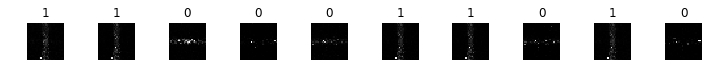

Epoch 3051/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.70
Epoch 3052/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 3053/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 3054/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 3055/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.71
Epoch 3056/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 3057/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 3058/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 3059/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 3060/4000  ||  D acc: 0.55, loss: 0.69  |  G loss: 0.70
Epoch 3061/4000  ||  D acc: 0.41, loss: 0.69  |  G loss: 0.70
Epoch 3062/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 3063/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 3064/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 3065/4000  ||  D acc: 0.48, loss: 0.70  |  G loss: 0.71
Epoch 3066/4000  ||  D acc: 0.50, loss: 0.67  |  G loss: 0.70
Epoch 30

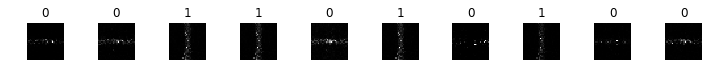

Epoch 3101/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 3102/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 3103/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 3104/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 3105/4000  ||  D acc: 0.41, loss: 0.69  |  G loss: 0.70
Epoch 3106/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 3107/4000  ||  D acc: 0.34, loss: 0.70  |  G loss: 0.70
Epoch 3108/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 3109/4000  ||  D acc: 0.41, loss: 0.69  |  G loss: 0.70
Epoch 3110/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3111/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3112/4000  ||  D acc: 0.58, loss: 0.69  |  G loss: 0.70
Epoch 3113/4000  ||  D acc: 0.33, loss: 0.70  |  G loss: 0.70
Epoch 3114/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 3115/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 3116/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 31

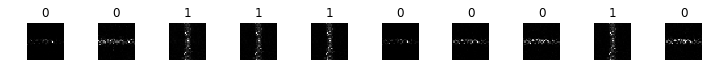

Epoch 3151/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3152/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 3153/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.71
Epoch 3154/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.71
Epoch 3155/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.71
Epoch 3156/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.71
Epoch 3157/4000  ||  D acc: 0.56, loss: 0.69  |  G loss: 0.71
Epoch 3158/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 3159/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.71
Epoch 3160/4000  ||  D acc: 0.52, loss: 0.68  |  G loss: 0.70
Epoch 3161/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.71
Epoch 3162/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 3163/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3164/4000  ||  D acc: 0.55, loss: 0.69  |  G loss: 0.70
Epoch 3165/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 3166/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 31

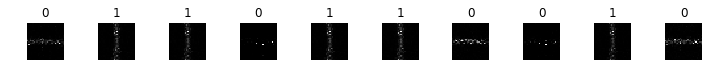

Epoch 3201/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 3202/4000  ||  D acc: 0.48, loss: 0.70  |  G loss: 0.70
Epoch 3203/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 3204/4000  ||  D acc: 0.38, loss: 0.69  |  G loss: 0.70
Epoch 3205/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 3206/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3207/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 3208/4000  ||  D acc: 0.55, loss: 0.69  |  G loss: 0.70
Epoch 3209/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.71
Epoch 3210/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.71
Epoch 3211/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 3212/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3213/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 3214/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.70
Epoch 3215/4000  ||  D acc: 0.50, loss: 0.68  |  G loss: 0.70
Epoch 3216/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 32

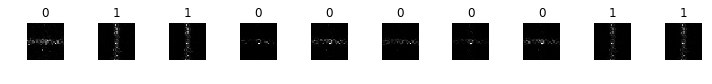

Epoch 3251/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 3252/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 3253/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 3254/4000  ||  D acc: 0.38, loss: 0.69  |  G loss: 0.70
Epoch 3255/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 3256/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.70
Epoch 3257/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 3258/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 3259/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 3260/4000  ||  D acc: 0.47, loss: 0.70  |  G loss: 0.70
Epoch 3261/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 3262/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 3263/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 3264/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3265/4000  ||  D acc: 0.34, loss: 0.70  |  G loss: 0.70
Epoch 3266/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 32

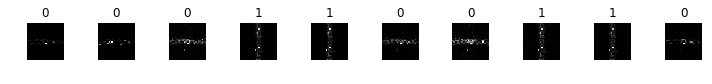

Epoch 3301/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 3302/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 3303/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 3304/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 3305/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 3306/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 3307/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 3308/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 3309/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 3310/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 3311/4000  ||  D acc: 0.41, loss: 0.69  |  G loss: 0.70
Epoch 3312/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 3313/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 3314/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 3315/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 3316/4000  ||  D acc: 0.47, loss: 0.68  |  G loss: 0.71
Epoch 33

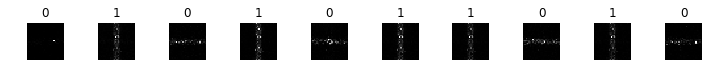

Epoch 3351/4000  ||  D acc: 0.55, loss: 0.69  |  G loss: 0.70
Epoch 3352/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 3353/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 3354/4000  ||  D acc: 0.55, loss: 0.69  |  G loss: 0.70
Epoch 3355/4000  ||  D acc: 0.34, loss: 0.70  |  G loss: 0.70
Epoch 3356/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3357/4000  ||  D acc: 0.47, loss: 0.70  |  G loss: 0.70
Epoch 3358/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 3359/4000  ||  D acc: 0.58, loss: 0.69  |  G loss: 0.70
Epoch 3360/4000  ||  D acc: 0.41, loss: 0.69  |  G loss: 0.70
Epoch 3361/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 3362/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 3363/4000  ||  D acc: 0.58, loss: 0.69  |  G loss: 0.70
Epoch 3364/4000  ||  D acc: 0.53, loss: 0.69  |  G loss: 0.70
Epoch 3365/4000  ||  D acc: 0.36, loss: 0.69  |  G loss: 0.70
Epoch 3366/4000  ||  D acc: 0.39, loss: 0.69  |  G loss: 0.70
Epoch 33

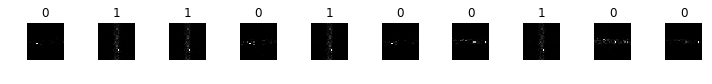

Epoch 3401/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 3402/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 3403/4000  ||  D acc: 0.31, loss: 0.70  |  G loss: 0.70
Epoch 3404/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 3405/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3406/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 3407/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 3408/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 3409/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3410/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 3411/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 3412/4000  ||  D acc: 0.33, loss: 0.70  |  G loss: 0.70
Epoch 3413/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 3414/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 3415/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 3416/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 34

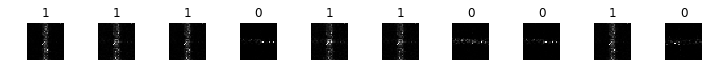

Epoch 3451/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 3452/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 3453/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3454/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 3455/4000  ||  D acc: 0.39, loss: 0.69  |  G loss: 0.70
Epoch 3456/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 3457/4000  ||  D acc: 0.56, loss: 0.69  |  G loss: 0.70
Epoch 3458/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3459/4000  ||  D acc: 0.39, loss: 0.69  |  G loss: 0.70
Epoch 3460/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 3461/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 3462/4000  ||  D acc: 0.48, loss: 0.68  |  G loss: 0.71
Epoch 3463/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.71
Epoch 3464/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.71
Epoch 3465/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 3466/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 34

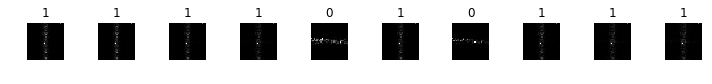

Epoch 3501/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 3502/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 3503/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 3504/4000  ||  D acc: 0.39, loss: 0.69  |  G loss: 0.70
Epoch 3505/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3506/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.71
Epoch 3507/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 3508/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 3509/4000  ||  D acc: 0.59, loss: 0.69  |  G loss: 0.70
Epoch 3510/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3511/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 3512/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 3513/4000  ||  D acc: 0.48, loss: 0.70  |  G loss: 0.70
Epoch 3514/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3515/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 3516/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.71
Epoch 35

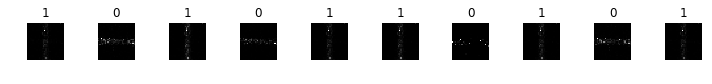

Epoch 3551/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.71
Epoch 3552/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 3553/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.71
Epoch 3554/4000  ||  D acc: 0.53, loss: 0.69  |  G loss: 0.71
Epoch 3555/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 3556/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.71
Epoch 3557/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.71
Epoch 3558/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.71
Epoch 3559/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 3560/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 3561/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.71
Epoch 3562/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.71
Epoch 3563/4000  ||  D acc: 0.53, loss: 0.69  |  G loss: 0.70
Epoch 3564/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.71
Epoch 3565/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 3566/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 35

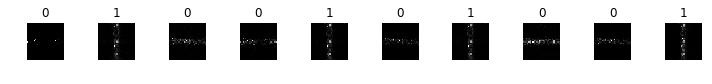

Epoch 3601/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.71
Epoch 3602/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 3603/4000  ||  D acc: 0.55, loss: 0.69  |  G loss: 0.70
Epoch 3604/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.71
Epoch 3605/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.71
Epoch 3606/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.71
Epoch 3607/4000  ||  D acc: 0.53, loss: 0.69  |  G loss: 0.70
Epoch 3608/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.71
Epoch 3609/4000  ||  D acc: 0.53, loss: 0.69  |  G loss: 0.70
Epoch 3610/4000  ||  D acc: 0.55, loss: 0.69  |  G loss: 0.71
Epoch 3611/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3612/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 3613/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 3614/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.71
Epoch 3615/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 3616/4000  ||  D acc: 0.39, loss: 0.69  |  G loss: 0.71
Epoch 36

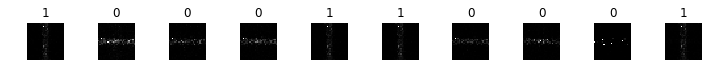

Epoch 3651/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.71
Epoch 3652/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 3653/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.71
Epoch 3654/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.71
Epoch 3655/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 3656/4000  ||  D acc: 0.48, loss: 0.68  |  G loss: 0.70
Epoch 3657/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 3658/4000  ||  D acc: 0.55, loss: 0.69  |  G loss: 0.70
Epoch 3659/4000  ||  D acc: 0.53, loss: 0.69  |  G loss: 0.70
Epoch 3660/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.71
Epoch 3661/4000  ||  D acc: 0.53, loss: 0.69  |  G loss: 0.70
Epoch 3662/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 3663/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 3664/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 3665/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 3666/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 36

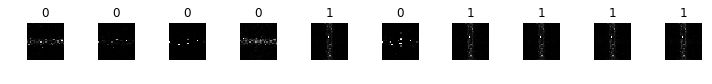

Epoch 3701/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.69
Epoch 3702/4000  ||  D acc: 0.47, loss: 0.70  |  G loss: 0.69
Epoch 3703/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.69
Epoch 3704/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.69
Epoch 3705/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 3706/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.69
Epoch 3707/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.69
Epoch 3708/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.69
Epoch 3709/4000  ||  D acc: 0.48, loss: 0.70  |  G loss: 0.69
Epoch 3710/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.69
Epoch 3711/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 3712/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 3713/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 3714/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3715/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 3716/4000  ||  D acc: 0.56, loss: 0.69  |  G loss: 0.70
Epoch 37

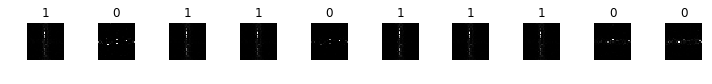

Epoch 3751/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.71
Epoch 3752/4000  ||  D acc: 0.44, loss: 0.70  |  G loss: 0.70
Epoch 3753/4000  ||  D acc: 0.53, loss: 0.69  |  G loss: 0.70
Epoch 3754/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.71
Epoch 3755/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.71
Epoch 3756/4000  ||  D acc: 0.48, loss: 0.70  |  G loss: 0.70
Epoch 3757/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 3758/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 3759/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 3760/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 3761/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 3762/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 3763/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3764/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3765/4000  ||  D acc: 0.38, loss: 0.69  |  G loss: 0.70
Epoch 3766/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 37

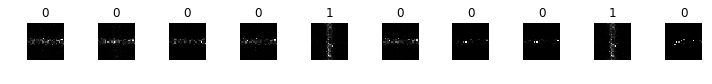

Epoch 3801/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3802/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 3803/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 3804/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.70
Epoch 3805/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 3806/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 3807/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 3808/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3809/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3810/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3811/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 3812/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 3813/4000  ||  D acc: 0.41, loss: 0.69  |  G loss: 0.72
Epoch 3814/4000  ||  D acc: 0.41, loss: 0.69  |  G loss: 0.71
Epoch 3815/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.73
Epoch 3816/4000  ||  D acc: 0.31, loss: 0.71  |  G loss: 0.70
Epoch 38

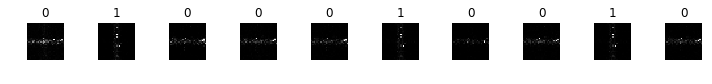

Epoch 3851/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3852/4000  ||  D acc: 0.48, loss: 0.70  |  G loss: 0.70
Epoch 3853/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 3854/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 3855/4000  ||  D acc: 0.39, loss: 0.69  |  G loss: 0.70
Epoch 3856/4000  ||  D acc: 0.55, loss: 0.69  |  G loss: 0.70
Epoch 3857/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 3858/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 3859/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 3860/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 3861/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 3862/4000  ||  D acc: 0.39, loss: 0.69  |  G loss: 0.70
Epoch 3863/4000  ||  D acc: 0.53, loss: 0.69  |  G loss: 0.70
Epoch 3864/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 3865/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 3866/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 38

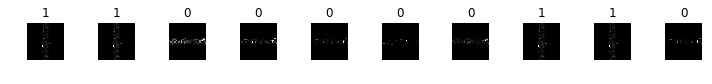

Epoch 3901/4000  ||  D acc: 0.31, loss: 0.70  |  G loss: 0.70
Epoch 3902/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 3903/4000  ||  D acc: 0.45, loss: 0.70  |  G loss: 0.70
Epoch 3904/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3905/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 3906/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 3907/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3908/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3909/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 3910/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 3911/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 3912/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 3913/4000  ||  D acc: 0.36, loss: 0.70  |  G loss: 0.70
Epoch 3914/4000  ||  D acc: 0.39, loss: 0.70  |  G loss: 0.70
Epoch 3915/4000  ||  D acc: 0.41, loss: 0.70  |  G loss: 0.70
Epoch 3916/4000  ||  D acc: 0.55, loss: 0.69  |  G loss: 0.70
Epoch 39

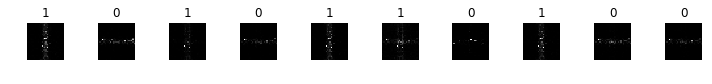

Epoch 3951/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 3952/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 3953/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 3954/4000  ||  D acc: 0.42, loss: 0.69  |  G loss: 0.70
Epoch 3955/4000  ||  D acc: 0.38, loss: 0.70  |  G loss: 0.70
Epoch 3956/4000  ||  D acc: 0.52, loss: 0.69  |  G loss: 0.70
Epoch 3957/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 3958/4000  ||  D acc: 0.39, loss: 0.69  |  G loss: 0.70
Epoch 3959/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 3960/4000  ||  D acc: 0.47, loss: 0.69  |  G loss: 0.70
Epoch 3961/4000  ||  D acc: 0.42, loss: 0.70  |  G loss: 0.70
Epoch 3962/4000  ||  D acc: 0.47, loss: 0.70  |  G loss: 0.70
Epoch 3963/4000  ||  D acc: 0.48, loss: 0.69  |  G loss: 0.70
Epoch 3964/4000  ||  D acc: 0.45, loss: 0.69  |  G loss: 0.70
Epoch 3965/4000  ||  D acc: 0.44, loss: 0.69  |  G loss: 0.70
Epoch 3966/4000  ||  D acc: 0.50, loss: 0.69  |  G loss: 0.70
Epoch 39

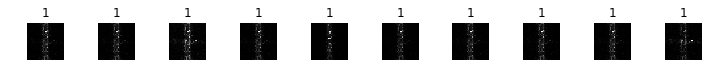

In [20]:
cdcgan.train(epochs=4000, batch_size=32, save_interval=50)

In [21]:
from keras.models import load_model
model1_g = load_model('./cdcgan/{}/models/generator.h5'.format(MODEL))

def generate_noise(dim1, dim2, mu=0, sigma=1):
    return np.random.normal(mu, sigma, (dim1, dim2))

/usr/local/lib/python3.5/dist-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


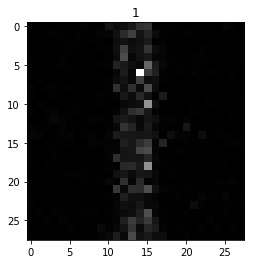

In [30]:
label = 1
noise = generate_noise(1, 100)
img = model1_g.predict([noise, np.array([label])]).reshape(28,28)

plt.imshow(img, cmap='gray')
plt.title(str(label))
plt.show()

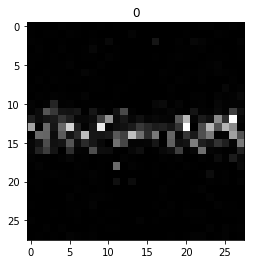

In [35]:
label = 0
noise = generate_noise(1, 100)
img = model1_g.predict([noise, np.array([label])]).reshape(28,28)

plt.imshow(img, cmap='gray')
plt.title(str(label))
plt.show()